# Sine Model Development
This is project to develop a sine estimation model for arduino uno. The model would be convert to a c header file. 

## Importing the necessary libraries

In [ ]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np
import matplotlib .pyplot as plt

from os import path
from tqdm.auto import tqdm

/home/matthias/Documents/EmbeddedAI/dlai/examples/sine_model/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining constants

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NO_SAMPLES = 1_000
LUCKY_NUMBER = 25
PI = 3.14159265359

TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.2

## Generating the dataset
The data will contain numbers between 0 and 2pi, the sine function will be defined in rad.
A random uniform error is added to the sine values to give the dataset a bit of variability and see how the model will perform.
The error is centred with a mean of 0 and std 0f 0.1. This is chosen such that 95% of the error is -0.25 and 0.+25.

In [3]:
np.random.seed(LUCKY_NUMBER)
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)

In [4]:
x = np.random.uniform(size=NO_SAMPLES, low=0, high=2*PI)
y = np.sin(x) + np.random.normal(loc=0, scale=.125, size=NO_SAMPLES)
x.shape, y.shape

((1000,), (1000,))

## Understanding the Dataset

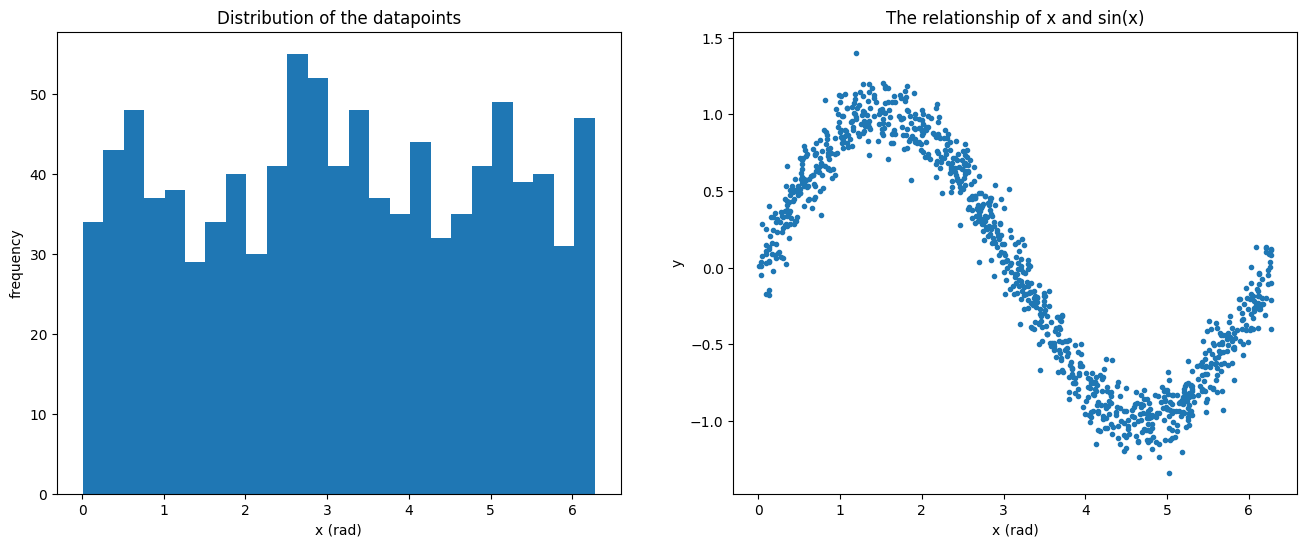

In [5]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6))

axes[0].hist(x, bins=25)
axes[0].set_ylabel("frequency")
axes[0].set_xlabel("x (rad)")
axes[0].set_title("Distribution of the datapoints")

axes[1].scatter(x, y, marker=".")
axes[1].set_ylabel("y")
axes[1].set_xlabel("x (rad)")
axes[1].set_title("The relationship of x and sin(x)")

plt.show()

## Preparing the Dataset

In [6]:
x_train, x_validate, x_test = np.array_split(x, [int(NO_SAMPLES*TRAIN_RATIO), int(NO_SAMPLES*(1-TEST_RATIO))])
y_train, y_validate, y_test = np.array_split(y, [int(NO_SAMPLES*TRAIN_RATIO), int(NO_SAMPLES*(1-TEST_RATIO))])

x_train.shape, x_validate.shape, x_test.shape, y_train.shape, y_validate.shape, y_test.shape

((700,), (100,), (200,), (700,), (100,), (200,))

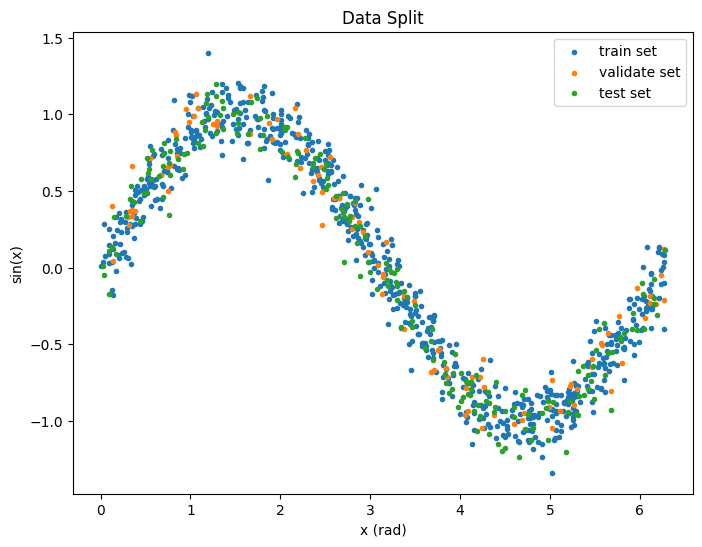

In [7]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(x_train, y_train, marker=".", label="train set")
ax.scatter(x_validate, y_validate, marker=".", label="validate set")
ax.scatter(x_test, y_test, marker=".", label="test set")
ax.set_xlabel("x (rad)")
ax.set_ylabel("sin(x)")
ax.set_title("Data Split")

ax.legend()


## Defining the model

In [8]:
sine_model_dlai = nn.Sequential(
    nn.Linear(in_features=1, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(DEVICE)

In [9]:
summary(sine_model_dlai, input_size=(1,1), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Linear: 1-1                            [1, 16]                   32
├─ReLU: 1-2                              [1, 16]                   --
├─Linear: 1-3                            [1, 16]                   272
├─ReLU: 1-4                              [1, 16]                   --
├─Linear: 1-5                            [1, 1]                    17
Total params: 321
Trainable params: 321
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Training the model

In [10]:
def fit(model, X_train, y_train, loss, optimizer="adam", epoches=10, batch_size=1, validation_set=None):
    history = dict()

    loss_fn = nn.MSELoss() if loss == "mse" else None

    optimizer_fn = torch.optim.Adam(model.parameters(), lr=1e-2) if optimizer == "adam" else None

    for epoch in tqdm(range(epoches)):
        
        model.train()
        y_train_pred = model(X_train)

        optimizer_fn.zero_grad()
        
        train_loss = loss_fn(y_train, y_train_pred)
        train_loss.backward()
        optimizer_fn.step()

        history["train_loss"] = history.get("train_loss", []) + [train_loss.item()]

        if validation_set:
            X_validate = validation_set[0]
            y_validate = validation_set[1]

            model.eval()
            with torch.inference_mode():
                y_validate_pred = model(X_validate)
            validate_loss = loss_fn(y_validate, y_validate_pred)

            history["validate_loss"] = history.get("validate_loss", []) + [validate_loss.item()]

            print(f"epoch {epoch}: training loss {train_loss:.4f} | validation loss {validate_loss:.4f}")
        else:
            print(f"epoch {epoch}: training loss {train_loss:.4f}")
    
    
    return history


In [11]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

history = fit(sine_model_dlai, x_train_tensor, y_train_tensor, "mse", optimizer="adam", epoches=1000, validation_set=(x_validate_tensor, y_validate_tensor))

  6%|▌         | 59/1000 [00:00<00:05, 166.66it/s]

epoch 0: training loss 0.5016 | validation loss 0.4581
epoch 1: training loss 0.4777 | validation loss 0.4424
epoch 2: training loss 0.4636 | validation loss 0.4279
epoch 3: training loss 0.4474 | validation loss 0.4163
epoch 4: training loss 0.4336 | validation loss 0.4050
epoch 5: training loss 0.4212 | validation loss 0.3903
epoch 6: training loss 0.4077 | validation loss 0.3710
epoch 7: training loss 0.3916 | validation loss 0.3549
epoch 8: training loss 0.3791 | validation loss 0.3409
epoch 9: training loss 0.3650 | validation loss 0.3275
epoch 10: training loss 0.3492 | validation loss 0.3160
epoch 11: training loss 0.3346 | validation loss 0.3031
epoch 12: training loss 0.3202 | validation loss 0.2863
epoch 13: training loss 0.3039 | validation loss 0.2685
epoch 14: training loss 0.2877 | validation loss 0.2520
epoch 15: training loss 0.2721 | validation loss 0.2363
epoch 16: training loss 0.2555 | validation loss 0.2219
epoch 17: training loss 0.2386 | validation loss 0.2092
ep

 17%|█▋        | 168/1000 [00:00<00:02, 350.38it/s]

epoch 115: training loss 0.0811 | validation loss 0.0848
epoch 116: training loss 0.0805 | validation loss 0.0849
epoch 117: training loss 0.0800 | validation loss 0.0830
epoch 118: training loss 0.0794 | validation loss 0.0828
epoch 119: training loss 0.0788 | validation loss 0.0829
epoch 120: training loss 0.0783 | validation loss 0.0812
epoch 121: training loss 0.0777 | validation loss 0.0808
epoch 122: training loss 0.0771 | validation loss 0.0808
epoch 123: training loss 0.0766 | validation loss 0.0793
epoch 124: training loss 0.0760 | validation loss 0.0788
epoch 125: training loss 0.0754 | validation loss 0.0788
epoch 126: training loss 0.0749 | validation loss 0.0775
epoch 127: training loss 0.0744 | validation loss 0.0772
epoch 128: training loss 0.0738 | validation loss 0.0770
epoch 129: training loss 0.0733 | validation loss 0.0757
epoch 130: training loss 0.0728 | validation loss 0.0755
epoch 131: training loss 0.0722 | validation loss 0.0751
epoch 132: training loss 0.0717

 29%|██▉       | 291/1000 [00:00<00:01, 463.93it/s]

epoch 235: training loss 0.0311 | validation loss 0.0292
epoch 236: training loss 0.0310 | validation loss 0.0310
epoch 237: training loss 0.0310 | validation loss 0.0287
epoch 238: training loss 0.0312 | validation loss 0.0333
epoch 239: training loss 0.0321 | validation loss 0.0299
epoch 240: training loss 0.0340 | validation loss 0.0401
epoch 241: training loss 0.0370 | validation loss 0.0329
epoch 242: training loss 0.0385 | validation loss 0.0374
epoch 243: training loss 0.0347 | validation loss 0.0277
epoch 244: training loss 0.0296 | validation loss 0.0276
epoch 245: training loss 0.0300 | validation loss 0.0358
epoch 246: training loss 0.0334 | validation loss 0.0287
epoch 247: training loss 0.0325 | validation loss 0.0289
epoch 248: training loss 0.0287 | validation loss 0.0300
epoch 249: training loss 0.0291 | validation loss 0.0280
epoch 250: training loss 0.0314 | validation loss 0.0313
epoch 251: training loss 0.0298 | validation loss 0.0270
epoch 252: training loss 0.0277

 41%|████▏     | 414/1000 [00:01<00:01, 456.60it/s]

epoch 353: training loss 0.0194 | validation loss 0.0193
epoch 354: training loss 0.0194 | validation loss 0.0189
epoch 355: training loss 0.0194 | validation loss 0.0194
epoch 356: training loss 0.0194 | validation loss 0.0189
epoch 357: training loss 0.0194 | validation loss 0.0195
epoch 358: training loss 0.0194 | validation loss 0.0188
epoch 359: training loss 0.0194 | validation loss 0.0195
epoch 360: training loss 0.0194 | validation loss 0.0188
epoch 361: training loss 0.0194 | validation loss 0.0196
epoch 362: training loss 0.0195 | validation loss 0.0189
epoch 363: training loss 0.0196 | validation loss 0.0200
epoch 364: training loss 0.0198 | validation loss 0.0191
epoch 365: training loss 0.0200 | validation loss 0.0208
epoch 366: training loss 0.0204 | validation loss 0.0198
epoch 367: training loss 0.0209 | validation loss 0.0220
epoch 368: training loss 0.0215 | validation loss 0.0207
epoch 369: training loss 0.0221 | validation loss 0.0230
epoch 370: training loss 0.0224

 53%|█████▎    | 534/1000 [00:01<00:00, 518.36it/s]

epoch 428: training loss 0.0199 | validation loss 0.0185
epoch 429: training loss 0.0188 | validation loss 0.0177
epoch 430: training loss 0.0183 | validation loss 0.0179
epoch 431: training loss 0.0186 | validation loss 0.0192
epoch 432: training loss 0.0193 | validation loss 0.0187
epoch 433: training loss 0.0195 | validation loss 0.0190
epoch 434: training loss 0.0191 | validation loss 0.0179
epoch 435: training loss 0.0185 | validation loss 0.0178
epoch 436: training loss 0.0182 | validation loss 0.0181
epoch 437: training loss 0.0184 | validation loss 0.0181
epoch 438: training loss 0.0188 | validation loss 0.0187
epoch 439: training loss 0.0189 | validation loss 0.0181
epoch 440: training loss 0.0187 | validation loss 0.0180
epoch 441: training loss 0.0184 | validation loss 0.0177
epoch 442: training loss 0.0182 | validation loss 0.0177
epoch 443: training loss 0.0183 | validation loss 0.0181
epoch 444: training loss 0.0185 | validation loss 0.0179
epoch 445: training loss 0.0186

 66%|██████▌   | 657/1000 [00:01<00:00, 563.94it/s]

epoch 555: training loss 0.0180 | validation loss 0.0176
epoch 556: training loss 0.0180 | validation loss 0.0176
epoch 557: training loss 0.0180 | validation loss 0.0177
epoch 558: training loss 0.0180 | validation loss 0.0176
epoch 559: training loss 0.0180 | validation loss 0.0175
epoch 560: training loss 0.0180 | validation loss 0.0175
epoch 561: training loss 0.0180 | validation loss 0.0176
epoch 562: training loss 0.0180 | validation loss 0.0176
epoch 563: training loss 0.0180 | validation loss 0.0176
epoch 564: training loss 0.0180 | validation loss 0.0176
epoch 565: training loss 0.0180 | validation loss 0.0175
epoch 566: training loss 0.0180 | validation loss 0.0176
epoch 567: training loss 0.0180 | validation loss 0.0176
epoch 568: training loss 0.0180 | validation loss 0.0175
epoch 569: training loss 0.0180 | validation loss 0.0175
epoch 570: training loss 0.0180 | validation loss 0.0175
epoch 571: training loss 0.0180 | validation loss 0.0176
epoch 572: training loss 0.0180

 78%|███████▊  | 776/1000 [00:01<00:00, 545.69it/s]

epoch 673: training loss 0.0180 | validation loss 0.0177
epoch 674: training loss 0.0180 | validation loss 0.0175
epoch 675: training loss 0.0180 | validation loss 0.0176
epoch 676: training loss 0.0180 | validation loss 0.0175
epoch 677: training loss 0.0180 | validation loss 0.0176
epoch 678: training loss 0.0179 | validation loss 0.0175
epoch 679: training loss 0.0179 | validation loss 0.0175
epoch 680: training loss 0.0179 | validation loss 0.0175
epoch 681: training loss 0.0179 | validation loss 0.0175
epoch 682: training loss 0.0179 | validation loss 0.0176
epoch 683: training loss 0.0180 | validation loss 0.0175
epoch 684: training loss 0.0180 | validation loss 0.0175
epoch 685: training loss 0.0180 | validation loss 0.0175
epoch 686: training loss 0.0180 | validation loss 0.0176
epoch 687: training loss 0.0180 | validation loss 0.0175
epoch 688: training loss 0.0180 | validation loss 0.0175
epoch 689: training loss 0.0180 | validation loss 0.0175
epoch 690: training loss 0.0180

 83%|████████▎ | 832/1000 [00:01<00:00, 492.50it/s]

epoch 779: training loss 0.0180 | validation loss 0.0176
epoch 780: training loss 0.0180 | validation loss 0.0176
epoch 781: training loss 0.0180 | validation loss 0.0175
epoch 782: training loss 0.0180 | validation loss 0.0175
epoch 783: training loss 0.0179 | validation loss 0.0175
epoch 784: training loss 0.0179 | validation loss 0.0175
epoch 785: training loss 0.0179 | validation loss 0.0175
epoch 786: training loss 0.0179 | validation loss 0.0175
epoch 787: training loss 0.0179 | validation loss 0.0175
epoch 788: training loss 0.0179 | validation loss 0.0175
epoch 789: training loss 0.0179 | validation loss 0.0175
epoch 790: training loss 0.0179 | validation loss 0.0175
epoch 791: training loss 0.0179 | validation loss 0.0175
epoch 792: training loss 0.0179 | validation loss 0.0175
epoch 793: training loss 0.0179 | validation loss 0.0175
epoch 794: training loss 0.0179 | validation loss 0.0175
epoch 795: training loss 0.0179 | validation loss 0.0175
epoch 796: training loss 0.0179

 94%|█████████▍| 945/1000 [00:02<00:00, 526.49it/s]

epoch 872: training loss 0.0199 | validation loss 0.0201
epoch 873: training loss 0.0204 | validation loss 0.0202
epoch 874: training loss 0.0209 | validation loss 0.0209
epoch 875: training loss 0.0212 | validation loss 0.0204
epoch 876: training loss 0.0211 | validation loss 0.0203
epoch 877: training loss 0.0206 | validation loss 0.0192
epoch 878: training loss 0.0198 | validation loss 0.0186
epoch 879: training loss 0.0189 | validation loss 0.0176
epoch 880: training loss 0.0182 | validation loss 0.0174
epoch 881: training loss 0.0179 | validation loss 0.0177
epoch 882: training loss 0.0181 | validation loss 0.0179
epoch 883: training loss 0.0185 | validation loss 0.0185
epoch 884: training loss 0.0189 | validation loss 0.0184
epoch 885: training loss 0.0190 | validation loss 0.0186
epoch 886: training loss 0.0189 | validation loss 0.0180
epoch 887: training loss 0.0186 | validation loss 0.0179
epoch 888: training loss 0.0182 | validation loss 0.0175
epoch 889: training loss 0.0180

100%|██████████| 1000/1000 [00:02<00:00, 457.01it/s]

epoch 998: training loss 0.0182 | validation loss 0.0176
epoch 999: training loss 0.0180 | validation loss 0.0174


Text(0.5, 1.0, 'Model loss')

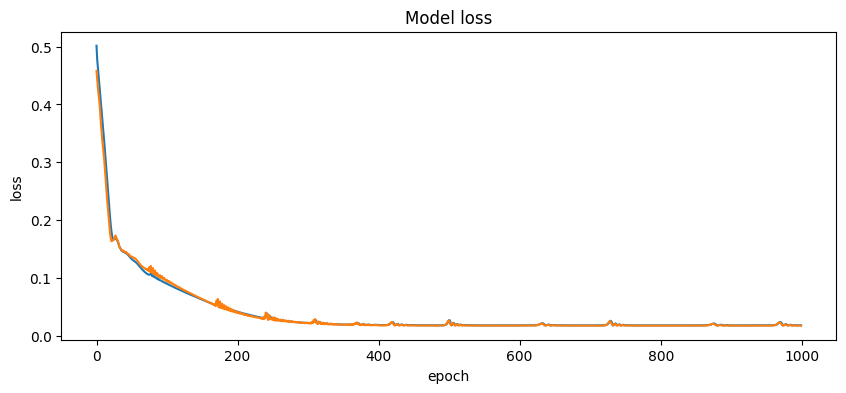

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(history["train_loss"])
ax.plot(history["validate_loss"])
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Model loss")

## Testing the model

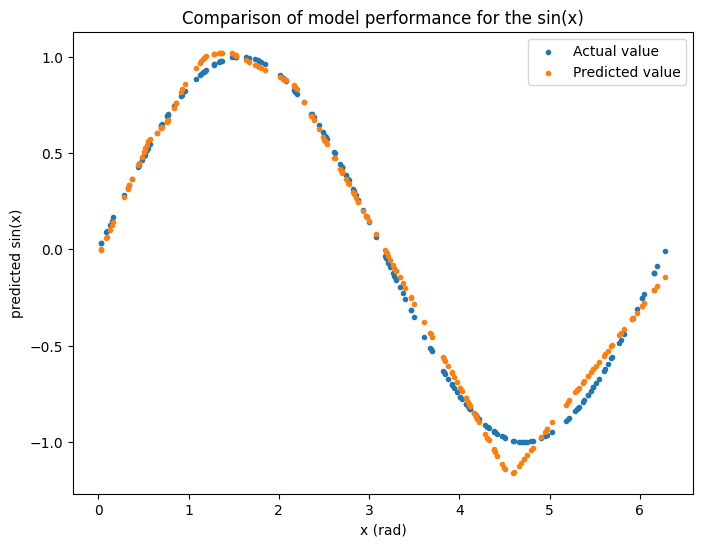

In [13]:
y_test_pred = sine_model_dlai(x_test_tensor).squeeze(dim=1).cpu().detach().numpy()

fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(x_test, np.sin(x_test), marker=".", label="Actual value")
ax.scatter(x_test, y_test_pred, marker=".", label="Predicted value")
ax.set_xlabel("x (rad)")
ax.set_ylabel("predicted sin(x)")
ax.set_title("Comparison of model performance for the sin(x)")
ax.legend()

In [14]:
for i in range(0, 360, 10):
    print(sine_model_dlai(torch.tensor([i*2*3.141/360]).to(DEVICE)))

tensor([-0.0358], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1511], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.3380], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.5249], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.6311], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.7699], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9194], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.0060], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.0225], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9958], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9552], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.9146], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.8740], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.7719], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.6224], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.4730], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.3235], device='cuda:0', grad_fn=<ViewBackward

## Saving the trained sine model

In [15]:
torch.save(sine_model_dlai, "sine_model.pth")


In [17]:
y_test_pred.min()

np.float32(-1.1598024)